# Exercise

Let's go back to our previous example on the astrophysical transient.

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

import pylab as py
import scipy.stats as stats
import corner

import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

To start, I download the data and I plot them with the time on the x-axis and the flux on the y-axis.

In [2]:
data = np.load('/Users/beasa/Desktop/astrostatistics_bicocca_2024/solutions/transient.npy')

time = data[:, 0]
flux = data[:, 1]
flux_unc = data[:, 2]

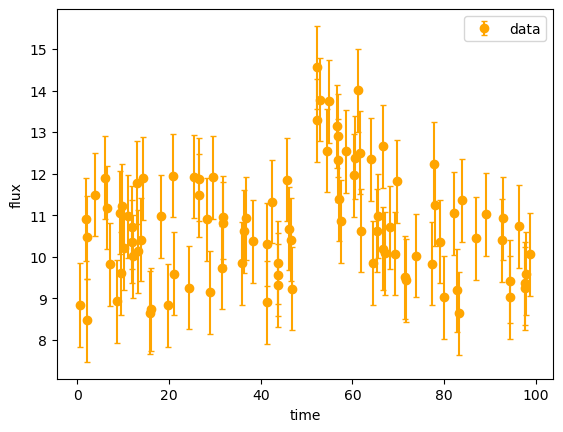

In [3]:
plt.errorbar(time, flux, yerr=flux_unc, xerr=None, fmt='o', capsize=2, ecolor='orange', color='orange', label='data')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

Then, I define the model and the minimum and maximum values for each parameter.

In [4]:
def model(tt, t_0, B, a, Alpha):
    if tt<t_0:
        return B
    else:
        return B+a*np.exp(-Alpha*(tt-t_0))

bmin, bmax = 0, 50
Amin, Amax = 0, 50
t0min, t0max = 0, 100
lnalphamin, lnalphamax = -5, 5
alphamin, alphamax = np.exp(lnalphamin), np.exp(lnalphamax)

After initializing the number of dimensions ($ndim = 4$ because of the four parameters of the model), I define two functions returning respectively the logarithm of the likelihood and the priors. 

In [18]:
ndim = 4

def log_likelihood(params, tt, Flux, flux_uncert):
    B, a, t_0, alpha2 = params
    Model = [model(T, t_0, B, a, alpha2) for T in tt]
    sigma1 = flux_uncert*flux_uncert
    
    return -np.sum((Flux-Model)*(Flux-Model)/sigma1)/2

def unifPrior(U):
    x = np.array(U)
    
    x[0] = stats.uniform(loc=Amin, scale=Amax-Amin).ppf(U[0])
    x[1] = stats.uniform(loc=bmin, scale=bmax-bmin).ppf(U[1])
    x[2] = stats.uniform(loc=t0min, scale=t0max-t0min).ppf(U[2])
    x[3] = stats.loguniform.ppf(U[3], alphamin, alphamax)
    
    return x

Then, I initialize the nested sampling algorithm by passing the logarithm of the likelihood and the priors. I run the sampler and I save the results of the run in an array ($sresults$).

In [27]:
sampler = dynesty.NestedSampler(log_likelihood, unifPrior, ndim, logl_args=[time, flux, flux_unc])
sampler.run_nested()
sresults = sampler.results

7650it [16:10,  7.88it/s, +500 | bound: 151 | nc: 1 | ncall: 130831 | eff(%):  6.253 | loglstar:   -inf < -48.774 <    inf | logz: -63.286 +/-  0.168 | dlogz:  0.001 >  0.509]


In what follows, I plot the results.

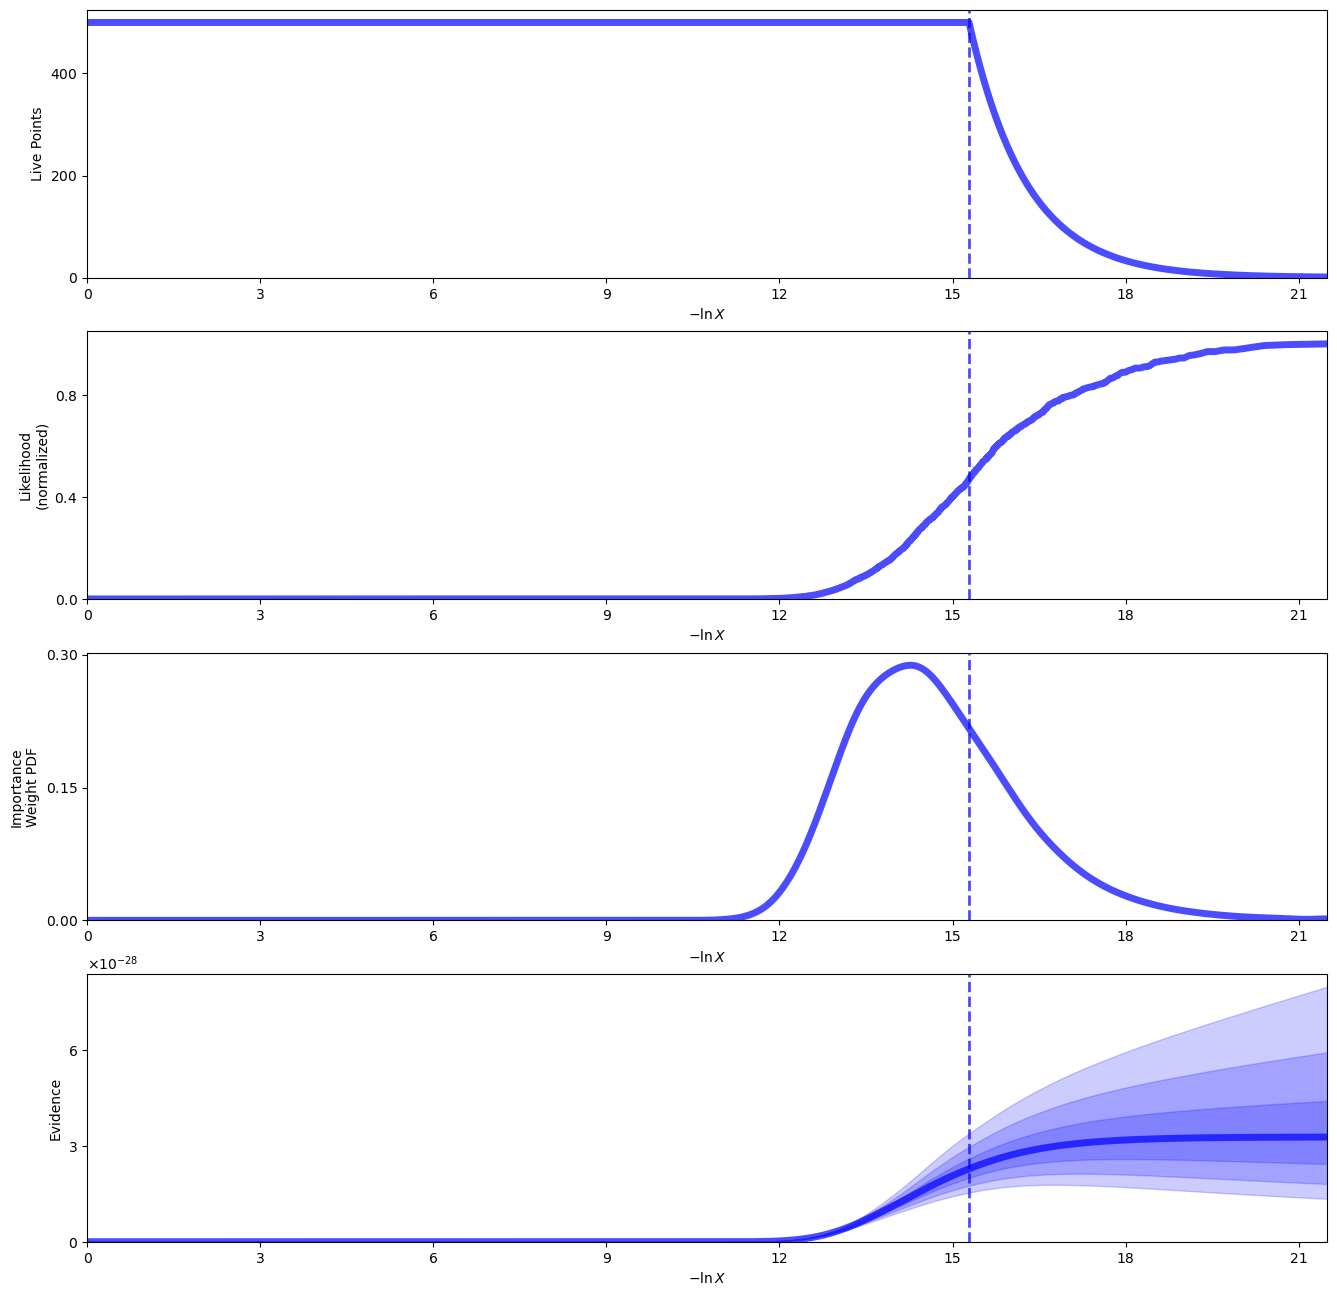

In [28]:
rfig, raxes = dyplot.runplot(sresults)

In particular (on the x-axis there is minus the logarithm of the prior parameter space):

1. Top plot. I am plotting the number of live points. As I can see, the number of points is constant during the nested sampling analysis, up to the end of the process, because each point is replaced by another one with higher probability.
2. Middle-top plot. It is represented the normalized likelihood. The likelihood increases as the nested sampling algorithm goes on because I am replacing low probability points with high probability ones.
3. Middle-bottom plot. This is the importance weight pdf: this plot represents the regions in the prior parameter space in which I have the maximum posterior probability.
4. Bottom plot. I am plotting the evidence with the corresponding $1-\sigma$, $2-\sigma$ and $3-\sigma$ uncertainty regions.


In what follows, instead, I am representing the parameter traces (left plots) and $1-D$ marginalized posteriors (right plots), for respectively $b$, $A$, $t_0$ and $ln(\alpha)$.

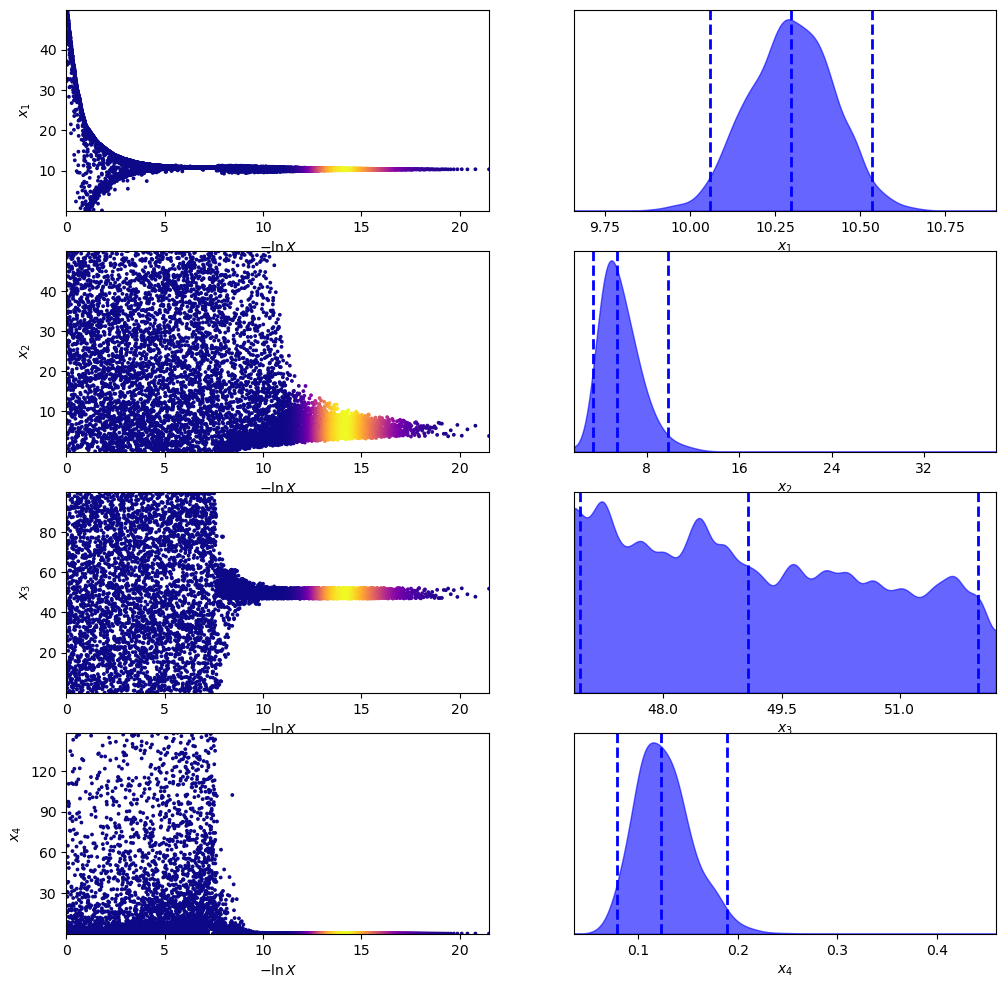

In [29]:
tfig, taxes = dyplot.traceplot(sresults)

Corner plot:

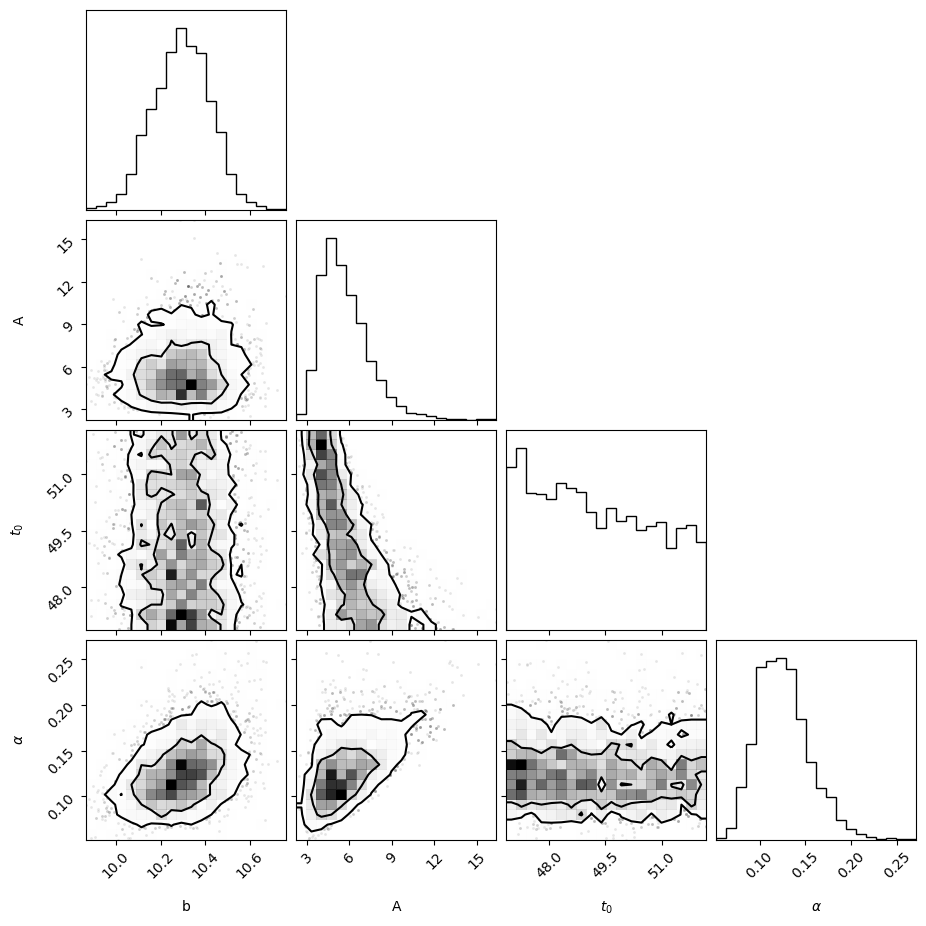

In [30]:
samples = sresults.samples
weights = np.exp(sresults.logwt-sresults.logz[-1])  # weights associated to each sample
new_samples = dyfunc.resample_equal(samples, weights)  # this new data set takes into account the weights

fig1 = corner.corner(new_samples, labels=['b', 'A', r'$t_0$', r'$\alpha$'], levels=[0.68, 0.95]);

Check:

In [34]:
bvalue_5, bmedian, bvalue_95 = np.percentile(new_samples[:, 0], [5, 50, 95])
Avalue_5, Amedian, Avalue_95 = np.percentile(new_samples[:, 1], [5, 50, 95])
t0value_5, t0median, t0value_95 = np.percentile(new_samples[:, 2], [5, 50, 95])
alphavalue_5, alphamedian, alphavalue_95 = np.percentile(new_samples[:, 3], [5, 50, 95])

print('b value: ', bmedian, ' +', bvalue_95-bmedian, ' -', bmedian-bvalue_5)
print('A value: ', Amedian, ' +', Avalue_95-Amedian, ' -', Amedian-Avalue_5)
print('t0 value: ', t0median, ' +', t0value_95-t0median, ' -', t0median-t0value_5)
print('alhpa value: ', alphamedian, ' +', alphavalue_95-alphamedian, ' -', alphamedian-alphavalue_5)

b value:  10.298019683641362  + 0.19648488581006518  - 0.20626469750381027
A value:  5.394813808656547  + 3.503593602964374  - 1.808164620373812
t0 value:  49.07768099534897  + 2.731450374383506  - 2.018025813506931
alhpa value:  0.12296041521559806  + 0.055664683481291916  - 0.037996190378273384


##### Gaussian model

I initialize the minimum and maximum values for the standard deviation, and then I define the Gaussian model, the logatirhm of the likelihood and the prior functions.

In [31]:
lnsigWmin, lnsigWmax = -2, 2
sigWmin, sigWmax = np.exp(lnsigWmin), np.exp(lnsigWmax)

In [32]:
def modelG(tt, t_0, B, a, sigW):
    return B+a*np.exp(-(tt-t_0)*(tt-t_0)/(2*sigW*sigW))

def log_likelihoodG(params, tt, Flux, flux_uncert):
    B, a, t_0, sigW = params
    ModelG = [modelG(T, t_0, B, a, sigW) for T in tt]
    sigma1 = flux_uncert*flux_uncert
    
    return -np.sum((Flux-ModelG)*(Flux-ModelG)/sigma1)/2

def unifPriorG(U):
    xG = np.array(U)
    
    xG[0] = stats.uniform(loc=Amin, scale=Amax-Amin).ppf(U[0])
    xG[1] = stats.uniform(loc=bmin, scale=bmax-bmin).ppf(U[1])
    xG[2] = stats.uniform(loc=t0min, scale=t0max-t0min).ppf(U[2])
    xG[3] = stats.loguniform.ppf(U[3], sigWmin, sigWmax)
    
    return xG

I initialize and run the nested sampling algorithm, and consequently I save the results in the array $sresultsG$.

In [33]:
samplerG = dynesty.NestedSampler(log_likelihoodG, unifPriorG, ndim, logl_args=[time, flux, flux_unc])
samplerG.run_nested()
sresultsG = samplerG.results

4753it [10:11,  8.78it/s, bound: 82 | nc: 19 | ncall: 80225 | eff(%):  5.925 | loglstar:   -inf < -77.364 <    inf | logz: -88.625 +/-  0.142 | dlogz: 26.219 >  0.509]     C:\Users\beasa\anaconda3\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4886it [10:40,  7.00it/s, bound: 87 | nc: 53 | ncall: 83961 | eff(%):  5.819 | loglstar:   -inf < -75.560 <    inf | logz: -87.028 +/-  0.144 | dlogz: 24.356 >  0.509] C:\Users\beasa\anaconda3\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using u

As before, I plot the results, the parameter traces and the marginalized posteriors.

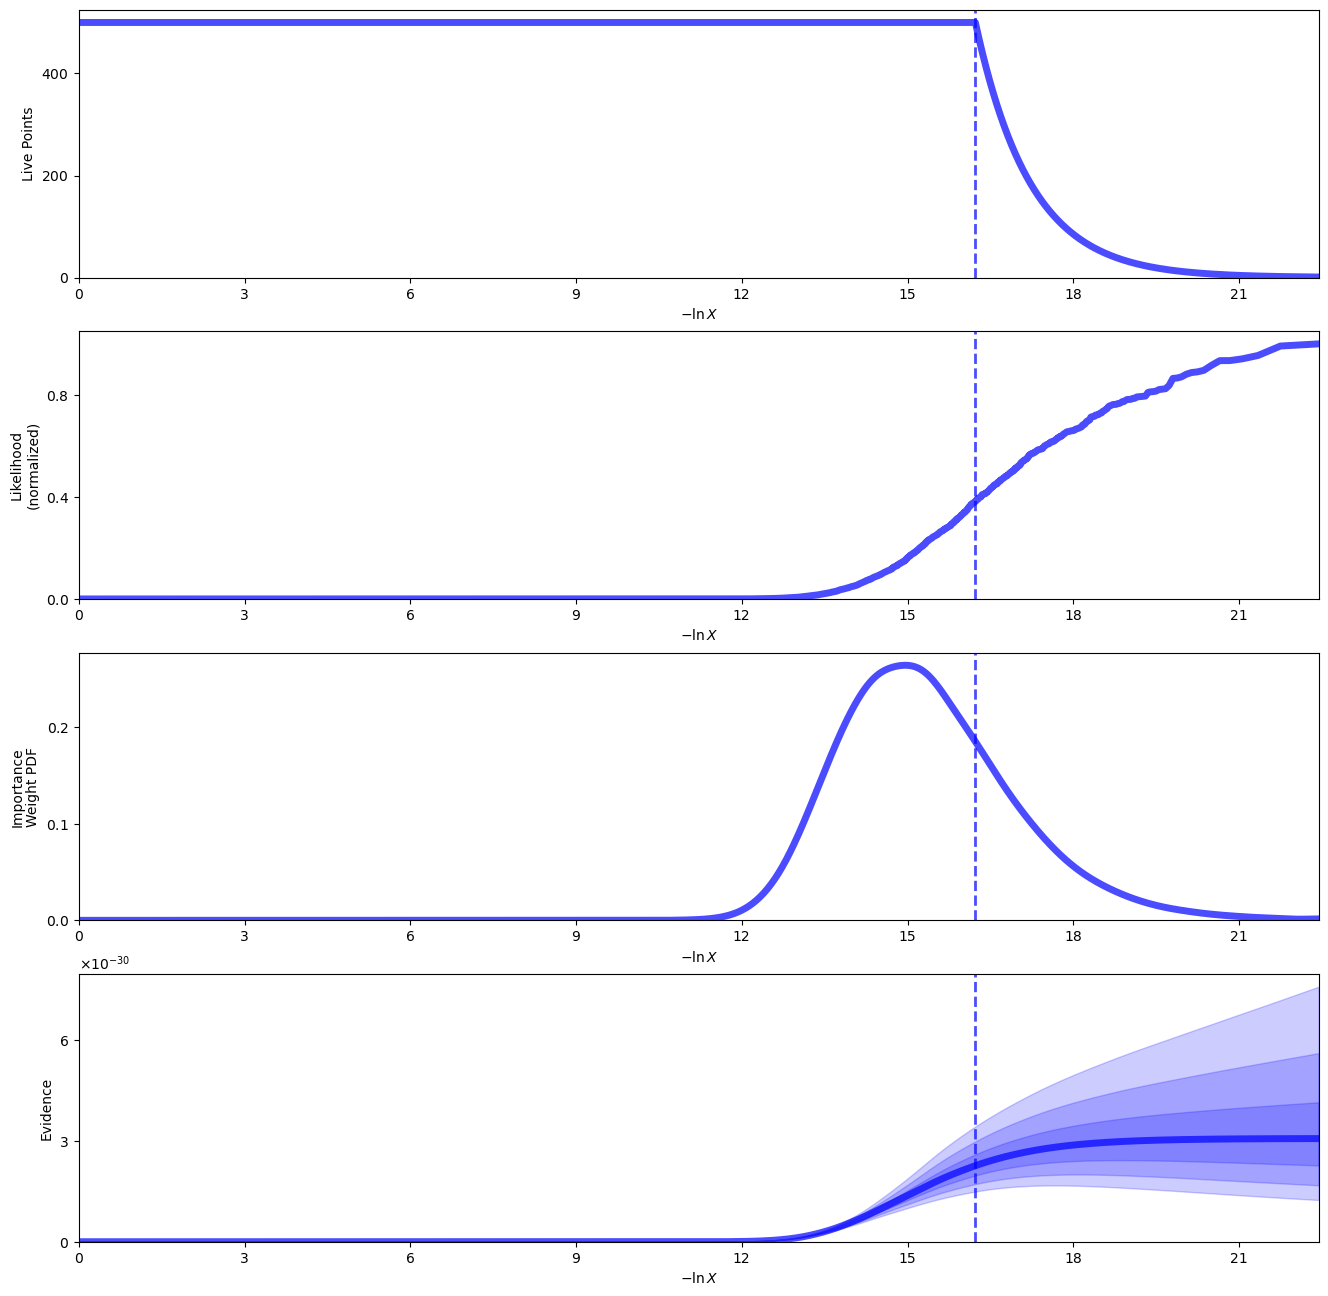

In [35]:
rfigG, raxesG = dyplot.runplot(sresultsG)

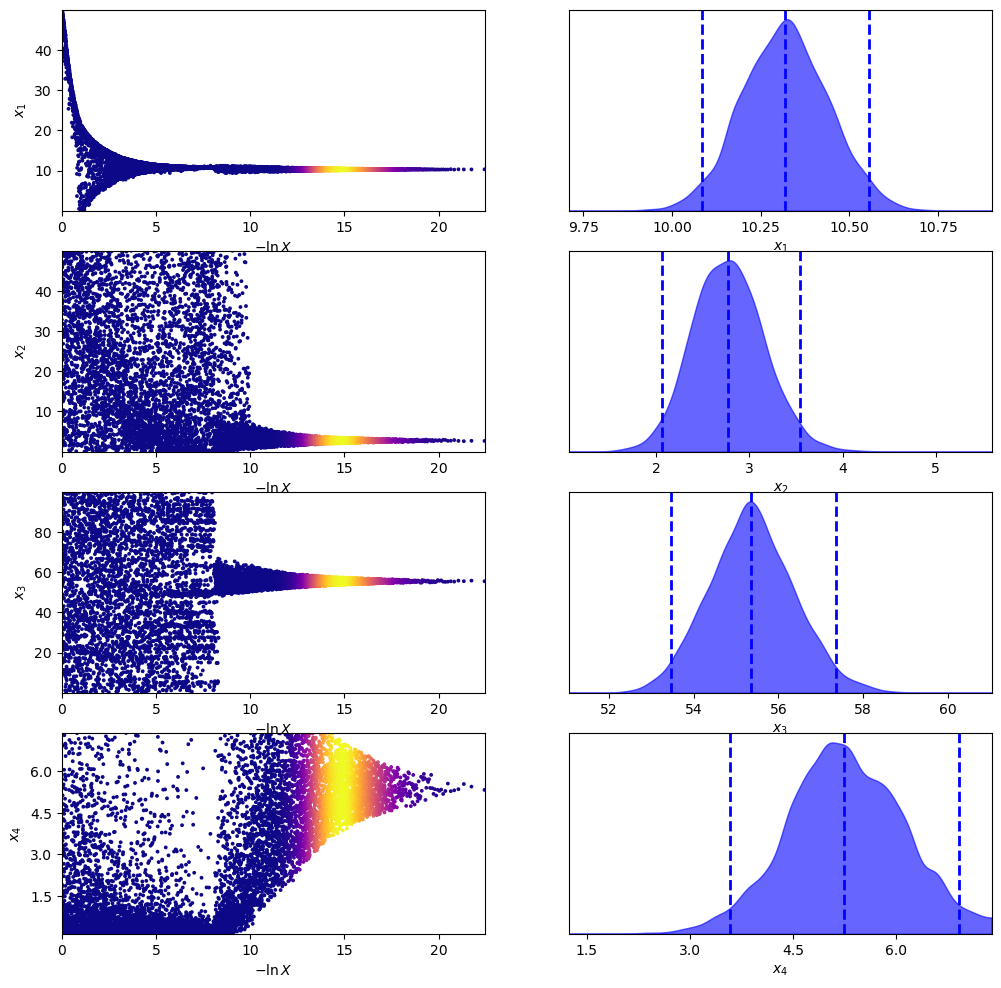

In [36]:
tfigG, taxesG = dyplot.traceplot(sresultsG)

Corner plot:

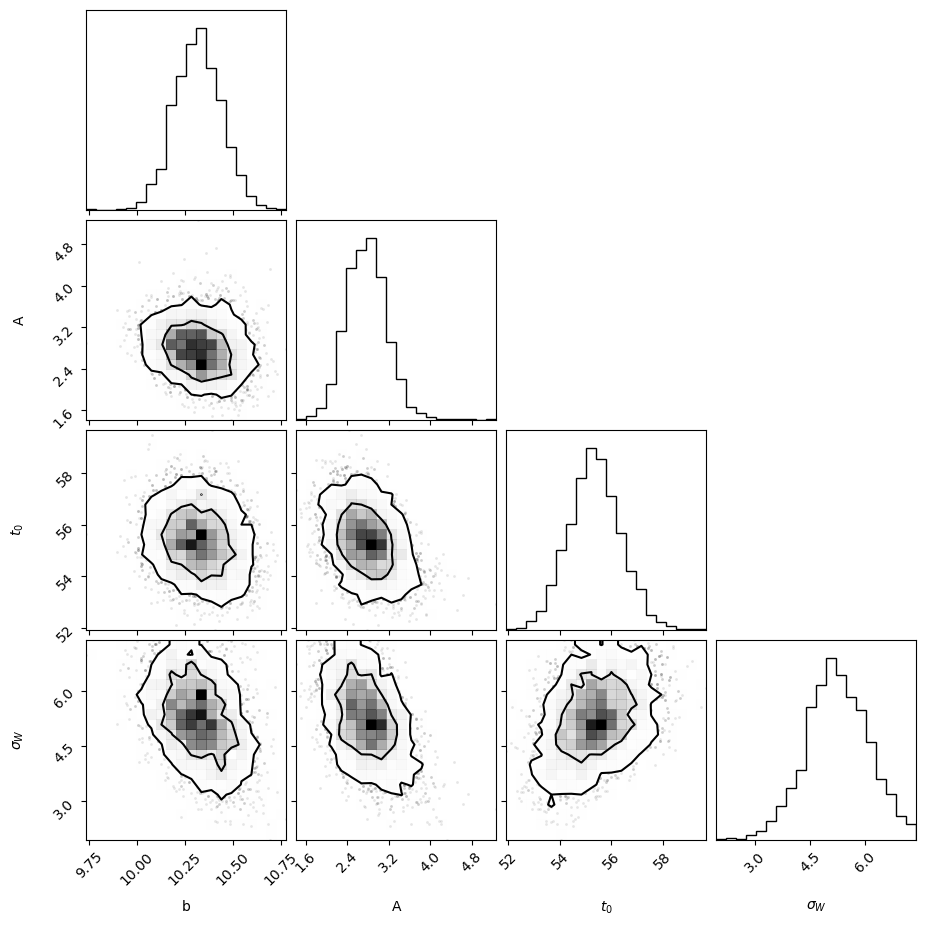

In [37]:
samplesG = sresultsG.samples
weightsG = np.exp(sresultsG.logwt-sresultsG.logz[-1])
new_samplesG = dyfunc.resample_equal(samplesG, weightsG)

fig2 = corner.corner(new_samplesG, labels=['b', 'A', r'$t_0$', r'$\sigma_W$'], levels=[0.68, 0.95]);

In [38]:
bvalue_5G, bmedianG, bvalue_95G = np.percentile(new_samplesG[:, 0], [5, 50, 95])
Avalue_5G, AmedianG, Avalue_95G = np.percentile(new_samplesG[:, 1], [5, 50, 95])
t0value_5G, t0medianG, t0value_95G = np.percentile(new_samplesG[:, 2], [5, 50, 95])
sigmavalue_5G, sigmamedianG, sigmavalue_95G = np.percentile(new_samplesG[:, 3], [5, 50, 95])

print('b value: ', bmedian, ' +', bvalue_95-bmedian, ' -', bmedian-bvalue_5)
print('A value: ', Amedian, ' +', Avalue_95-Amedian, ' -', Amedian-Avalue_5)
print('t0 value: ', t0median, ' +', t0value_95-t0median, ' -', t0median-t0value_5)
print('sigma value: ', sigmamedianG, ' +', sigmavalue_95G-sigmamedianG, ' -', sigmamedianG-sigmavalue_5G)

b value:  10.298019683641362  + 0.19648488581006518  - 0.20626469750381027
A value:  5.394813808656547  + 3.503593602964374  - 1.808164620373812
t0 value:  49.07768099534897  + 2.731450374383506  - 2.018025813506931
sigma value:  5.240672447702352  + 1.4053058026281713  - 1.390316990634675


##### Bayesian evidence ($Z$) and Odds ratio

I compute the Bayesian evidence for both the models.

In [39]:
Z1 = np.exp(sresults.logz[-1])
Z2 = np.exp(sresultsG.logz[-1])

In [41]:
print('Bayesian evidence for the burst model: ', Z1)
print('Bayesian evidence for the Gaussian model: ', Z2)

Bayesian evidence for the burst model:  3.2738541822882293e-28
Bayesian evidence for the Gaussian model:  3.0717234245487058e-30


And the Odds ratio between model $1$ and model $2$.

In [42]:
oddsRatio = Z1/Z2

print('The Odds ratio is: ', oddsRatio)

The Odds ratio is:  106.5803697079017


As I can see, model $1$ is strongly favoured with respect to model $2$, therefore the model that better describes the transient data is the first one.